In [1]:
import pickle
import time

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table

import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm

In [2]:
def count_all(data, thr):
    tp = ((data['preds'] >= thr) * (data['target'] == 1)).sum()
    fp = ((data['preds'] >= thr) * (data['target'] == 0)).sum()
    tn = ((data['preds'] < thr) * (data['target'] == 0)).sum()
    fn = ((data['preds'] < thr) * (data['target'] == 1)).sum()
    
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return prec, recall, fpr

def plot_all(data, quants, thrs, data_name, cumul=False, plot_obj_num=True):
    precs = []
    recalls = []
    fpr_1 = []
    sample_num = []
    for i in range(len(quants)-1):
        if cumul:
            t = data[data['Z'] >= quants[i]]
        else:
            t = data[(data['Z'] >= quants[i]) & (data['Z'] <= quants[i+1])]
        prec, recall, fpr = count_all(t, thrs[i])
        precs.append(prec)
        recalls.append(recall)
        fpr_1.append(1-fpr)
        sample_num.append((t[t['target'] == 0].shape[0], t[t['target'] == 1].shape[0]))
        
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(20, 8))
    plt.xlim(quants[0]-0.01, quants[-1]+0.01)
    plt.ylim(0, 1.02)
    plt.xticks(np.arange(int(quants[0]), 7.5, 0.5), rotation=45)
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    plt.grid()
    
    plt.plot((quants[1:] + quants[:-1]) / 2, precs, label=f'prec', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, recalls, label=f'recall', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, fpr_1, label=f'1-fpr', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, thrs, label=f'thresholds', marker='o')
    plt.vlines(quants, ymin=-0.5, ymax=1.5, colors='black')
    if plot_obj_num:
        for i, x in enumerate(((quants[1:] + quants[:-1]) / 2) - 0.05):
            plt.text(x, 0.52, f'{sample_num[i][0]}', size=7, c='b')
            plt.text(x, 0.48, f'{sample_num[i][1]}', size=7, c='r')
    plt.legend()
    plt.xlabel('Redshift')
    plt.ylabel('prec|recall|1-fpr')
    plt.title(f'{data_name}');
    
    return precs, recalls, fpr_1

In [3]:
data_dir = 'data'

np.random.seed(0)

In [4]:
with open(f'{data_dir}/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    photo_features_list = pickle.load(f)

In [5]:
ge = pd.read_csv(f'{data_dir}/dr16q_outliers_georgeedit.csv')
ge = ge[~ge['Gtest_zooTrue'].isna()]

In [6]:
ge

,RA,DEC,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,OBJID,Z_DR16Q,Z_SYS,Unnamed: 7,Gtest_zooTrue,GVZ
8,37.545812,0.526264,2.224000,0.443851,b'7828-57039-0800',3.008434,3.011951,https://dr16.sdss.org/optical/spectrum/view?pl...,False,3.00843381881714
218,23.391086,0.251862,3.480444,0.479422,b'8791-57373-0975',3.350000,3.355428,http://skyserver.sdss.org/dr16/en/tools/explor...,False,NaN
219,22.046334,8.744134,1.555033,0.254457,b'11075-58451-0094',3.350390,3.353816,https://dr16.sdss.org/optical/spectrum/view?pl...,False,3.35039
220,156.391114,42.721542,0.828373,0.321219,b'4557-55588-0816',3.356074,3.299605,http://skyserver.sdss.org/dr12/en/get/SpecById...,True,0.893
226,344.164440,-0.512493,1.490696,0.230164,b'9152-58041-0613',3.374726,3.366920,http://skyserver.sdss.org/dr16/en/tools/explor...,False,3.3747258
287,341.952704,-1.877977,2.459000,0.519390,b'4363-55537-0962',3.511198,3.511198,http://skyserver.sdss.org/dr15/en/tools/explor...,True,NaN
288,335.315805,-0.168170,1.003877,0.783286,b'9239-58018-0048',3.511224,3.535490,http://skyserver.sdss.org/dr9/en/tools/quicklo...,True,0.927
352,1.496255,-0.587194,0.534199,0.177835,b'7862-56984-0328',3.747000,3.713303,http://skyserver.sdss.org/dr12/en/tools/explor...,False,3.7133
353,350.468529,3.285160,1.092000,0.733817,b'11289-58398-0697',3.749070,3.749070,http://skyserver.sdss.org/dr16/en/tools/explor...,True,NaN
354,226.501787,49.752228,1.159823,0.575383,b'8432-57834-0962',3.750000,3.750000,http://skyserver.sdss.org/dr16/en/get/SpecById...,True,NaN


In [7]:
full = pd.read_csv(f'{data_dir}/full_dr16q_train20_superset.csv')
full = full.merge(ge[['OBJID', 'Gtest_zooTrue']], on=['OBJID'], how='left')
full.replace(np.nan, None, inplace=True)

/tmp/ipykernel_1531123/2307139392.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  full = pd.read_csv(f'{data_dir}/full_dr16q_train20_superset.csv')


In [8]:
full = full[full['Z'] > -1]
# full = full[full['Z_SYS'] > -1]
full = full[~full['max35_z'].isna()]
full['z_diff'] = full['max35_z'] - full['Z']
full['z_diff_abs'] = np.abs(full['z_diff'])
full['target'] = [None] * full.shape[0]
full.loc[full['superset'], 'target'] = 1
full.loc[full['train20'] & ~full['dr16q_prop'], 'target'] = 0
full['preds'] = [None] * full.shape[0]
full.reset_index(drop=True, inplace=True)
full

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.433418,1.855865,0.346749,2.028873,0.274436,None,-0.006618,0.006618,None,None
1,b'7695-57654-0565',0.001526,27.732283,1.770552,1.77408,0.002622,0.003528,0.003528,True,False,...,0.691206,1.752056,0.689963,1.682694,0.613794,None,-0.087857,0.087857,None,None
2,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.37172,1.627,0.446391,1.613,0.561226,None,0.038773,0.038773,None,None
3,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.422922,2.368,0.576355,2.121082,0.503914,None,-0.187918,0.187918,0,None
4,b'4216-55477-0310',0.001978,-0.451088,0.250000,0.250093,0.000271,0.000093,0.000093,True,False,...,0.479988,0.32021,0.185194,0.3508,0.702891,None,0.1008,0.1008,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201514,None,201.934129,12.271040,7.021599,None,None,None,None,False,False,...,None,None,None,2.900859,0.345879,None,-4.12074,4.12074,1,None
1201515,None,36.002095,-0.394057,7.027864,None,None,None,None,False,False,...,None,None,None,2.023643,0.290574,None,-5.004221,5.004221,1,None
1201516,None,179.515381,45.946690,7.029899,None,None,None,None,False,False,...,None,None,None,0.735022,0.589784,None,-6.294876,6.294876,1,None
1201517,None,0.306355,6.436817,7.030458,None,None,None,None,False,False,...,None,None,None,0.373313,0.168273,None,-6.657146,6.657146,1,None


In [9]:
train_20 = full[full['train20'] & ~full['dr16q_prop']].copy()
train_20.reset_index(drop=True, inplace=True)
train_20

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.422922,2.368,0.576355,2.121082,0.503914,None,-0.187918,0.187918,0,None
1,b'8740-57367-0694',0.002375,5.941903,2.102771,2.09378,0.003675,-0.008992,0.008992,True,False,...,0.382401,0.916635,0.653894,0.801,0.485579,None,-1.301771,1.301771,0,None
2,b'6177-56268-0595',0.002756,14.974675,2.497000,2.502681,0.002898,0.005681,0.005681,True,False,...,0.664471,2.625,0.634396,2.404,0.824371,None,-0.093,0.093,0,None
3,b'4415-55831-0464',0.004052,4.829781,1.619000,1.623999,0.002157,0.004999,0.004999,True,False,...,0.646769,1.446038,0.493191,1.453583,0.519208,None,-0.165417,0.165417,0,None
4,b'7666-57339-0121',0.005026,24.065163,1.615983,1.617055,0.000892,0.001073,0.001073,True,False,...,0.165052,0.457034,0.216048,0.566647,0.282821,None,-1.049335,1.049335,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575553,None,359.989649,17.861844,1.146000,None,None,None,None,False,False,...,0.33023,1.423635,0.318768,1.199739,0.469563,None,0.053739,0.053739,0,None
575554,None,359.989956,5.066145,0.334862,None,None,None,None,False,False,...,0.349578,0.235084,0.294244,0.165135,0.131182,None,-0.169727,0.169727,0,None
575555,None,359.992068,18.476645,1.283000,None,None,None,None,False,False,...,0.590475,1.317722,0.490772,1.221652,0.570182,None,-0.061348,0.061348,0,None
575556,None,359.994125,3.739318,0.483395,None,None,None,None,False,False,...,0.947357,0.495814,0.878827,0.507,0.983596,None,0.023605,0.023605,0,None


In [10]:
train_20_01, train_20_02 = train_20.iloc[range(0, train_20.shape[0], 2)], train_20.iloc[range(0, train_20.shape[0], 2)]

In [11]:
superset = full[full['superset']].copy()
superset.reset_index(drop=True, inplace=True)
superset

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,None,119.299997,22.527369,-0.011447,None,None,None,None,False,False,...,None,None,None,3.359,0.637353,None,3.370447,3.370447,1,None
1,None,262.134784,36.734522,-0.011332,None,None,None,None,False,False,...,None,None,None,3.164,0.500935,None,3.175332,3.175332,1,None
2,None,327.439561,-0.195568,-0.011123,None,None,None,None,False,False,...,None,None,None,3.139719,0.272778,None,3.150843,3.150843,1,None
3,None,217.129032,15.540025,-0.010959,None,None,None,None,False,False,...,None,None,None,3.412,0.350389,None,3.422959,3.422959,1,None
4,None,183.414213,0.751143,-0.010932,None,None,None,None,False,False,...,None,None,None,3.135,0.333385,None,3.145932,3.145932,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365340,None,201.934129,12.271040,7.021599,None,None,None,None,False,False,...,None,None,None,2.900859,0.345879,None,-4.12074,4.12074,1,None
365341,None,36.002095,-0.394057,7.027864,None,None,None,None,False,False,...,None,None,None,2.023643,0.290574,None,-5.004221,5.004221,1,None
365342,None,179.515381,45.946690,7.029899,None,None,None,None,False,False,...,None,None,None,0.735022,0.589784,None,-6.294876,6.294876,1,None
365343,None,0.306355,6.436817,7.030458,None,None,None,None,False,False,...,None,None,None,0.373313,0.168273,None,-6.657146,6.657146,1,None


In [12]:
superset_01, superset_02 = superset.iloc[range(0, superset.shape[0], 2)], superset.iloc[range(0, superset.shape[0], 2)]

In [13]:
dr16q = full[(full['dr16q']) & ~(full['train20'])].copy()
dr16q.reset_index(drop=True, inplace=True)
dr16q

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.433418,1.855865,0.346749,2.028873,0.274436,None,-0.006618,0.006618,None,None
1,b'7695-57654-0565',0.001526,27.732283,1.770552,1.77408,0.002622,0.003528,0.003528,True,False,...,0.691206,1.752056,0.689963,1.682694,0.613794,None,-0.087857,0.087857,None,None
2,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.37172,1.627,0.446391,1.613,0.561226,None,0.038773,0.038773,None,None
3,b'4216-55477-0310',0.001978,-0.451088,0.250000,0.250093,0.000271,0.000093,0.000093,True,False,...,0.479988,0.32021,0.185194,0.3508,0.702891,None,0.1008,0.1008,None,None
4,b'7749-58073-0683',0.002595,31.328982,1.991313,1.987004,0.00234,-0.004309,0.004309,True,False,...,0.799845,2.53,0.459704,2.049,0.92964,None,0.057687,0.057687,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260344,b'7167-56604-0276',359.997573,-9.826069,2.439000,2.439799,0.006409,0.000799,0.000799,True,False,...,0.745153,2.232917,0.616561,2.522,0.733557,None,0.083,0.083,None,None
260345,b'1489-52991-0520',359.997675,0.144870,1.356595,1.358383,0.002561,0.001788,0.001788,True,False,...,0.686697,1.102664,0.727626,1.175745,0.7415,None,-0.18085,0.18085,None,None
260346,b'11546-58488-0078',359.997704,10.564075,1.284287,1.285613,0.000508,0.001326,0.001326,True,False,...,0.877846,1.457419,0.719128,1.451017,0.844344,None,0.16673,0.16673,None,None
260347,b'7848-56959-0054',359.998520,-0.655884,1.355954,1.355999,0.000794,0.000045,0.000045,True,False,...,0.271965,1.096616,0.451444,1.078204,0.492389,None,-0.277751,0.277751,None,None


In [14]:
full_dr16q = full[(full['dr16q'])].copy()
full_dr16q.reset_index(drop=True, inplace=True)
full_dr16q

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.433418,1.855865,0.346749,2.028873,0.274436,None,-0.006618,0.006618,None,None
1,b'7695-57654-0565',0.001526,27.732283,1.770552,1.77408,0.002622,0.003528,0.003528,True,False,...,0.691206,1.752056,0.689963,1.682694,0.613794,None,-0.087857,0.087857,None,None
2,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.37172,1.627,0.446391,1.613,0.561226,None,0.038773,0.038773,None,None
3,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.422922,2.368,0.576355,2.121082,0.503914,None,-0.187918,0.187918,0,None
4,b'4216-55477-0310',0.001978,-0.451088,0.250000,0.250093,0.000271,0.000093,0.000093,True,False,...,0.479988,0.32021,0.185194,0.3508,0.702891,None,0.1008,0.1008,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696478,b'6182-56190-0380',359.998922,10.116800,2.415000,2.422902,0.004639,0.007902,0.007902,True,False,...,0.289139,2.62,0.275886,2.598,0.508071,None,0.183,0.183,0,None
696479,b'7666-57339-0130',359.999028,24.413548,1.490356,1.488036,0.001223,-0.00232,0.00232,True,False,...,0.353289,1.471,0.272345,1.519121,0.532895,None,0.028765,0.028765,0,None
696480,b'7134-56566-0408',359.999118,28.954734,2.452000,2.4514,0.00525,-0.0006,0.0006,True,False,...,0.583509,2.416101,0.459684,2.333,0.82793,None,-0.119,0.119,0,None
696481,b'8741-57390-0060',359.999615,3.268586,1.232962,1.233783,0.000758,0.000821,0.000821,True,False,...,0.80364,1.163,0.854128,1.319833,0.751813,None,0.086871,0.086871,0,None


In [15]:
prop_dr16q = full[(full['dr16q_prop'])].copy()
prop_dr16q.reset_index(drop=True, inplace=True)
prop_dr16q

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,b'7750-58402-0178',0.023199,33.677090,2.374468,1.695454,0.002444,-0.679013,0.679013,True,True,...,0.613625,1.635,0.836528,1.611,0.780039,None,-0.763468,0.763468,None,None
1,b'7751-58081-0010',0.110519,32.520371,6.537026,3.9,-1.0,-2.637026,2.637026,True,True,...,0.679745,0.67,0.366796,0.8,0.541579,None,-5.737026,5.737026,None,None
2,b'7666-57339-0127',0.182396,24.708938,2.812042,2.055525,0.002691,-0.756517,0.756517,True,True,...,0.435133,2.068,0.623723,2.120766,0.951724,None,-0.691276,0.691276,None,None
3,b'7749-58073-0317',0.200670,30.933965,3.346067,0.884013,0.0006,-2.462054,2.462054,True,True,...,0.834586,0.757478,0.543481,0.771,0.717006,None,-2.575067,2.575067,None,None
4,b'11277-58450-0221',0.447432,8.302736,1.619089,1.096916,0.001626,-0.522173,0.522173,True,True,...,0.250491,2.83514,0.406042,1.327,0.388721,None,-0.292089,0.292089,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,b'7696-57655-0810',359.586721,30.006652,7.012407,1.040394,0.000788,-5.972012,5.972012,True,True,...,0.265288,1.619793,0.314681,0.916,0.264474,None,-6.096407,6.096407,None,None
1657,b'7895-57659-0798',359.602008,-3.155726,4.471740,1.416833,0.002218,-3.054907,3.054907,True,True,...,0.913761,1.2609,0.711733,1.4614,0.979128,None,-3.01034,3.01034,None,None
1658,b'7848-56959-0147',359.688329,-0.107161,1.077307,0.638959,0.003373,-0.438348,0.438348,True,True,...,0.437292,1.976696,0.526514,1.718474,0.514749,None,0.641167,0.641167,None,None
1659,b'7895-57659-0851',359.854208,-3.659661,3.333653,0.894096,0.000511,-2.439556,2.439556,True,True,...,0.640537,0.69,0.685679,0.929,0.826316,None,-2.404653,2.404653,None,None


In [16]:
prop = []
prop_y = []
r = []
for i in np.arange(0.0, 7.0, 0.5):
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    min_shape = min(t1.shape[0], t2.shape[0])
    prop.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=min_shape, replace=False)])
    prop_y += [0] * min_shape
    prop.append(t2)
    prop_y += [1] * t2.shape[0]
    r.append((min_shape, min_shape == t2.shape[0]))
prop = pd.concat(prop, axis=0)

tree = KDTree(prop[['RA', 'DEC']].values)
d, idx = tree.query(train_20_02[['RA', 'DEC']])
t = train_20_02.drop(train_20_02.index[d.reshape(-1) < 0.0000001])
s = 0
for e in r:
    if e[1]:
        s += e[0]
diff = sum(prop_y) - (len(prop_y) - sum(prop_y))
prop_02 = []
for k, i in enumerate(np.arange(0.0, 7.0, 0.5)):
    if r[k][1]:
        t1 = t[(t['Z'] >= i) & (t['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
        prop_02.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=round(diff * r[k][0] / s), replace=False)])
prop = pd.concat((prop, pd.concat(prop_02)))
prop_y += [0] * (prop.shape[0] - len(prop_y))

prop['target'] = prop_y
prop.sort_values(by=['Z'], inplace=True)
prop.reset_index(drop=True, inplace=True)
prop

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,b'10465-58144-0576',157.601672,31.589120,0.004153,1.63156,0.002181,1.627407,1.627407,True,True,...,0.832505,1.7382,0.740722,1.6341,0.628845,None,1.629947,1.629947,1,None
1,b'11067-58507-0992',21.348922,16.562467,0.006583,1.123435,0.003304,1.116852,1.116852,True,True,...,0.522181,0.964192,0.365059,0.944,0.551885,None,0.937417,0.937417,1,None
2,b'7415-57097-0842',191.619513,49.916623,0.008189,1.560199,0.002642,1.552009,1.552009,True,True,...,0.51898,2.934,0.620699,2.06014,0.699425,None,2.051951,2.051951,1,None
3,b'7770-58044-0993',350.520778,30.096626,0.010326,0.990284,0.001618,0.979958,0.979958,True,True,...,0.538031,1.160254,0.557961,1.017882,0.6879,None,1.007555,1.007555,1,None
4,b'8535-58019-0894',256.791721,45.663833,0.015376,1.377521,0.002196,1.362145,1.362145,True,True,...,0.221669,3.127373,0.246699,1.934525,0.162386,None,1.919149,1.919149,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,b'8409-57867-0736',214.826084,58.821845,6.968736,1.19712,0.003626,-5.771616,5.771616,True,True,...,0.312503,0.434161,0.354641,0.411527,0.142483,None,-6.557209,6.557209,1,None
3256,b'9141-57663-0826',321.941715,0.395795,6.970199,1.613146,0.014746,-5.357052,5.357052,True,True,...,0.523849,1.232,0.558743,0.628432,0.107931,None,-6.341766,6.341766,1,None
3257,b'10754-58224-0524',218.509881,35.990135,6.977830,1.620841,0.003511,-5.356989,5.356989,True,True,...,0.261155,2.113928,0.416936,1.767968,0.429205,None,-5.209862,5.209862,1,None
3258,b'7237-56662-0450',32.666131,-5.778303,6.999089,0.967996,0.001876,-6.031093,6.031093,True,True,...,0.575919,1.065,0.424528,0.827,0.508095,None,-6.172089,6.172089,1,None


In [17]:
prop_balance = []
prop_balance_y = []
for i in np.arange(0.0, 7.0, 0.5):
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    min_shape = min(t1.shape[0], t2.shape[0])
    prop_balance.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=min_shape, replace=False)])
    prop_balance_y += [0] * min_shape
    prop_balance.append(t2.iloc[np.random.choice(np.arange(t2.shape[0]), size=min_shape, replace=False)])
    prop_balance_y += [1] * min_shape
prop_balance = pd.concat(prop_balance, axis=0)
prop_balance['target'] = prop_balance_y
prop_balance.sort_values(by=['Z'], inplace=True)
prop_balance.reset_index(drop=True, inplace=True)
prop_balance

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,b'10465-58144-0576',157.601672,31.589120,0.004153,1.63156,0.002181,1.627407,1.627407,True,True,...,0.832505,1.7382,0.740722,1.6341,0.628845,None,1.629947,1.629947,1,None
1,b'11067-58507-0992',21.348922,16.562467,0.006583,1.123435,0.003304,1.116852,1.116852,True,True,...,0.522181,0.964192,0.365059,0.944,0.551885,None,0.937417,0.937417,1,None
2,b'7415-57097-0842',191.619513,49.916623,0.008189,1.560199,0.002642,1.552009,1.552009,True,True,...,0.51898,2.934,0.620699,2.06014,0.699425,None,2.051951,2.051951,1,None
3,b'7770-58044-0993',350.520778,30.096626,0.010326,0.990284,0.001618,0.979958,0.979958,True,True,...,0.538031,1.160254,0.557961,1.017882,0.6879,None,1.007555,1.007555,1,None
4,b'8535-58019-0894',256.791721,45.663833,0.015376,1.377521,0.002196,1.362145,1.362145,True,True,...,0.221669,3.127373,0.246699,1.934525,0.162386,None,1.919149,1.919149,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,b'8842-57424-0311',176.589805,39.141618,6.464488,1.119064,0.004094,-5.345423,5.345423,True,True,...,0.370009,1.03913,0.559089,1.089322,0.567684,None,-5.375165,5.375165,1,None
2700,b'8404-57481-0777',219.767067,51.270692,6.520423,0.825711,0.000419,-5.694712,5.694712,True,True,...,0.527912,0.887432,0.481012,0.649,0.16748,None,-5.871423,5.871423,1,None
2701,None,36.507807,3.049838,6.541200,None,None,None,None,False,False,...,0.359223,6.5881,0.798716,0.923953,0.100922,None,-5.617247,5.617247,0,None
2702,b'11052-58438-0877',26.799025,14.903653,6.558784,1.113971,0.000774,-5.444813,5.444813,True,True,...,0.413852,2.245687,0.263431,1.999,0.596517,None,-4.559784,4.559784,1,None


In [18]:
prop_dens = []
prop_dens_y = []
for i in np.arange(0.0, 7.0, 0.5):
    t0 = full_dr16q[(full_dr16q['Z'] >= i) & (full_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    prop_dens.append(t2)
    prop_dens_y += [1] * t2.shape[0]
    print(t1.shape)
    prop_dens.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=t0.shape[0]-t2.shape[0], replace=True)])
    prop_dens_y += [0] * (t0.shape[0]-t2.shape[0])
prop_dens = pd.concat(prop_dens, axis=0)
prop_dens['target'] = prop_dens_y
prop_dens.sort_values(by=['Z'], inplace=True)
prop_dens.reset_index(drop=True, inplace=True)
prop_dens

(50168, 90)
(55291, 90)
(41479, 90)
(45864, 90)
(47820, 90)
(30631, 90)
(12146, 90)
(3354, 90)
(723, 90)
(189, 90)
(46, 90)
(33, 90)
(16, 90)
(2, 90)


,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,None,159.898630,0.058012,0.000146,None,None,None,None,False,False,...,0.176738,0.186749,0.166752,3.236,0.264705,None,3.235854,3.235854,0,None
1,None,159.898630,0.058012,0.000146,None,None,None,None,False,False,...,0.176738,0.186749,0.166752,3.236,0.264705,None,3.235854,3.235854,0,None
2,None,133.487654,8.900324,0.000147,None,None,None,None,False,False,...,0.908937,0.158648,0.95301,0.15711,0.934801,None,0.156963,0.156963,0,None
3,None,18.821771,26.332595,0.000339,None,None,None,None,False,False,...,0.271159,2.054265,0.280984,1.9929,0.227073,None,1.992561,1.992561,0,None
4,None,193.271875,46.627116,0.000438,None,None,None,None,False,False,...,0.16232,1.068,0.351798,0.786234,0.160532,None,0.785796,0.785796,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696445,b'8409-57867-0736',214.826084,58.821845,6.968736,1.19712,0.003626,-5.771616,5.771616,True,True,...,0.312503,0.434161,0.354641,0.411527,0.142483,None,-6.557209,6.557209,1,None
696446,b'9141-57663-0826',321.941715,0.395795,6.970199,1.613146,0.014746,-5.357052,5.357052,True,True,...,0.523849,1.232,0.558743,0.628432,0.107931,None,-6.341766,6.341766,1,None
696447,b'10754-58224-0524',218.509881,35.990135,6.977830,1.620841,0.003511,-5.356989,5.356989,True,True,...,0.261155,2.113928,0.416936,1.767968,0.429205,None,-5.209862,5.209862,1,None
696448,b'7237-56662-0450',32.666131,-5.778303,6.999089,0.967996,0.001876,-6.031093,6.031093,True,True,...,0.575919,1.065,0.424528,0.827,0.508095,None,-6.172089,6.172089,1,None


In [19]:
i = 6.5
train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
0,None,36.507807,3.049838,6.541200,None,None,None,None,False,False,...,0.359223,6.5881,0.798716,0.923953,0.100922,None,-5.617247,5.617247,0,None
1,None,174.891806,49.894562,6.795398,None,None,None,None,False,False,...,0.375718,0.837,0.479773,0.8006,0.406705,None,-5.994798,5.994798,0,None


In [20]:
features_list = ['z_diff_abs', 'conf35_z'] + photo_features_list

In [21]:
X_01 = np.concatenate([train_20_01[features_list].values, superset_01[features_list].values], axis=0)
y_01 = np.concatenate([train_20_01['target'].values, superset_01['target'].values], axis=0).astype(int)
X_02 = np.concatenate([train_20_02[features_list].values, superset_02[features_list].values], axis=0)
y_02 = np.concatenate([train_20_02['target'].values, superset_02['target'].values], axis=0).astype(int)

test = pd.concat((train_20_02, superset_02))

In [22]:
y_01.sum(), y_01.shape

(182673, (470452,))

In [23]:
import warnings
warnings.filterwarnings('ignore')

start = time.time()

boost = lgbm.LGBMClassifier(
    n_estimators=1000, max_depth=6,
    n_jobs=8
)
boost.fit(
    X_01, y_01, 
    # eval_set=[
    #     (X_02, y_02) 
    # ], 
    verbose=50
)

print('boost train time: ', time.time() - start)

boost train time:  30.27986788749695


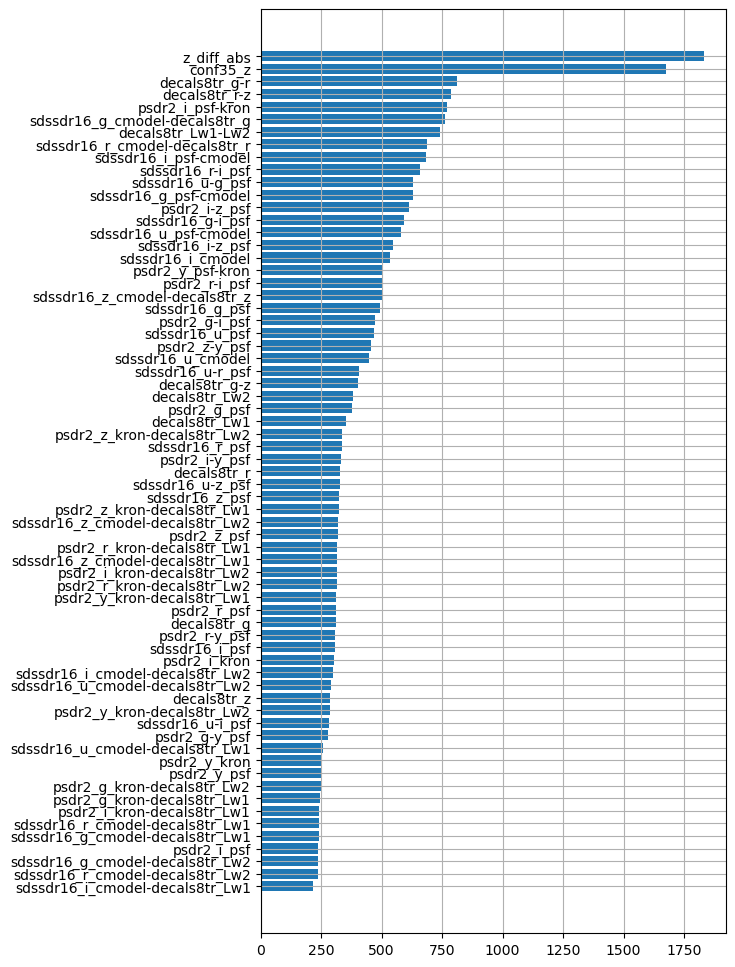

In [24]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(6, 12))
plt.grid()

plt.barh(np.array(features_list)[boost.feature_importances_.argsort()[::]], sorted(boost.feature_importances_)[::]);

In [25]:
start = time.time()
prop_dens_preds = boost.predict_proba(prop_dens[features_list].values.astype(float))[:, 1]
print('boost inf time: ', time.time() - start)
prop_dens['preds'] = prop_dens_preds
dr16q_preds = boost.predict_proba(dr16q[features_list].values.astype(float))[:, 1]
dr16q['preds'] = dr16q_preds
prop_dr16q_preds = boost.predict_proba(prop_dr16q[features_list].values.astype(float))[:, 1]
prop_dr16q['preds'] = prop_dr16q_preds

boost inf time:  15.097532749176025


In [26]:
quants = np.arange(4.0, 7.1, 0.5)
prop_dens_z = prop_dens[prop_dens['Z'] >= 4]

In [27]:
# font = {'size': 16}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(14, 12))
# plt.grid()

# plt.scatter(prop_dens_z[prop_dens_z['dr16q_prop']]['Z'], prop_dens_z[prop_dens_z['dr16q_prop']]['preds'], label='dr16q_prop')
# plt.scatter(prop_dens_z[prop_dens_z['train20']]['Z'], prop_dens_z[prop_dens_z['train20']]['preds'], label='train20')
# plt.xlabel('z_spec')
# plt.ylabel('score')
# plt.legend()
# pass;

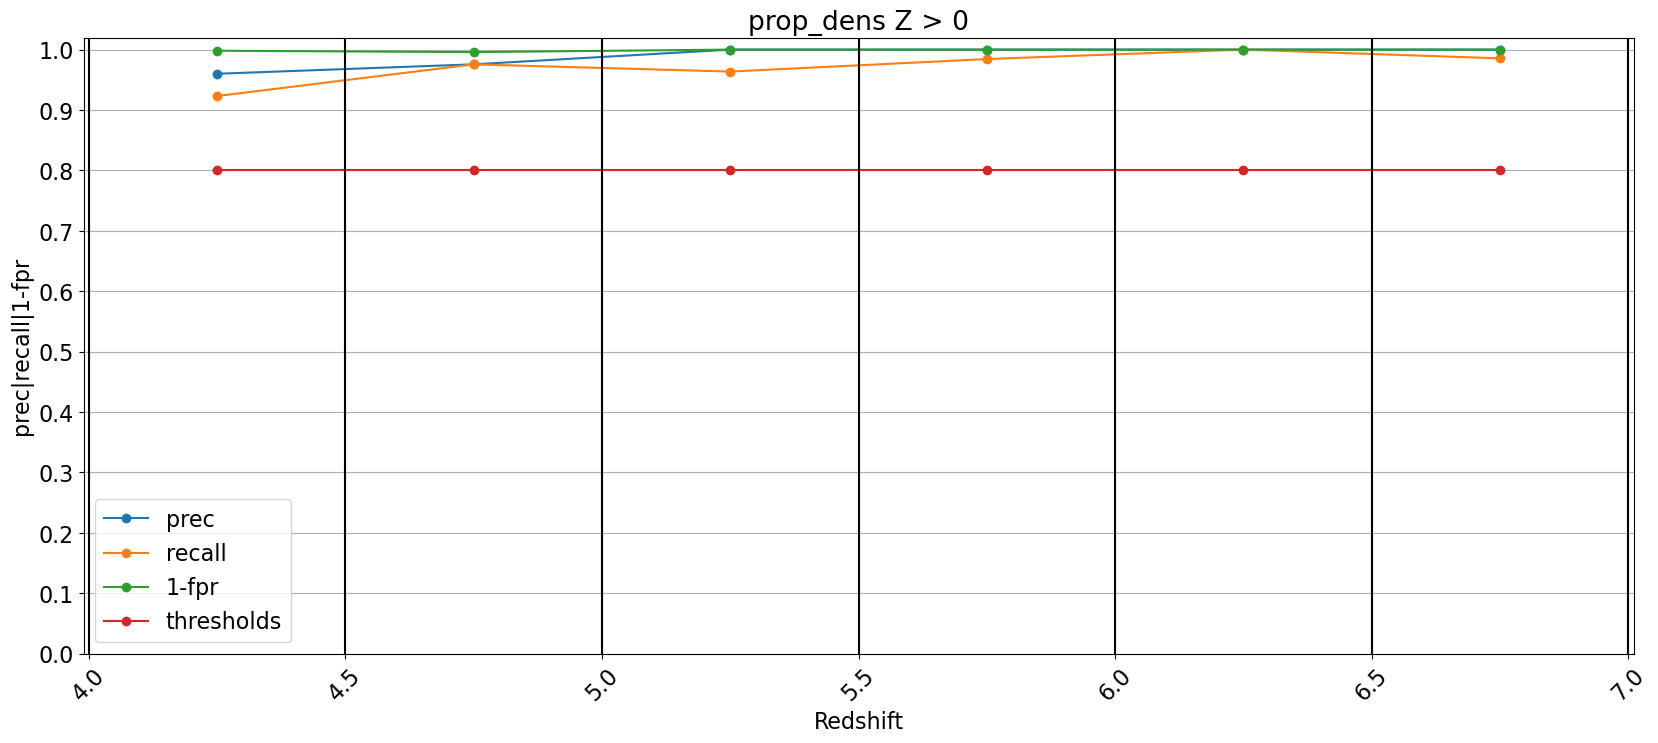

In [28]:
# manual_prec = []
# for i in range(len(quants)-1):
#     t = ge[(ge['Z_DR16Q'] >= quants[i]) & (ge['Z_DR16Q'] <= quants[i+1])]
#     manual_prec.append(t['Gtest_zooTrue'].sum() / t.shape[0])

# thrs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
thrs = [0.8] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_z, quants, thrs, 'prop_dens Z > 0', plot_obj_num=False)
# plt.plot((quants[1:] + quants[:-1]) / 2, manual_prec, label=f'manual_prec', marker='o')
# plt.legend();

In [53]:
count_all(prop_dens_z, 0.8)

(0.9904761904761905, 0.9719626168224299, 0.002242152466367713)

In [29]:
# manual_prec = []
# for i in quants[:-1]:
#     t = ge[ge['Z_DR16Q'] >= i]
#     manual_prec.append(t['Gtest_zooTrue'].sum() / t.shape[0])

# # thrs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
# thrs = [0.8] * (len(quants)-1)

# _, _, _ = plot_all(prop_dens_z, quants, thrs, 'prop_dens Z > 3 CUMULATIVE', cumul=True)
# plt.plot((quants[1:] + quants[:-1]) / 2, manual_prec, label=f'manual_prec', marker='o')
# plt.legend();

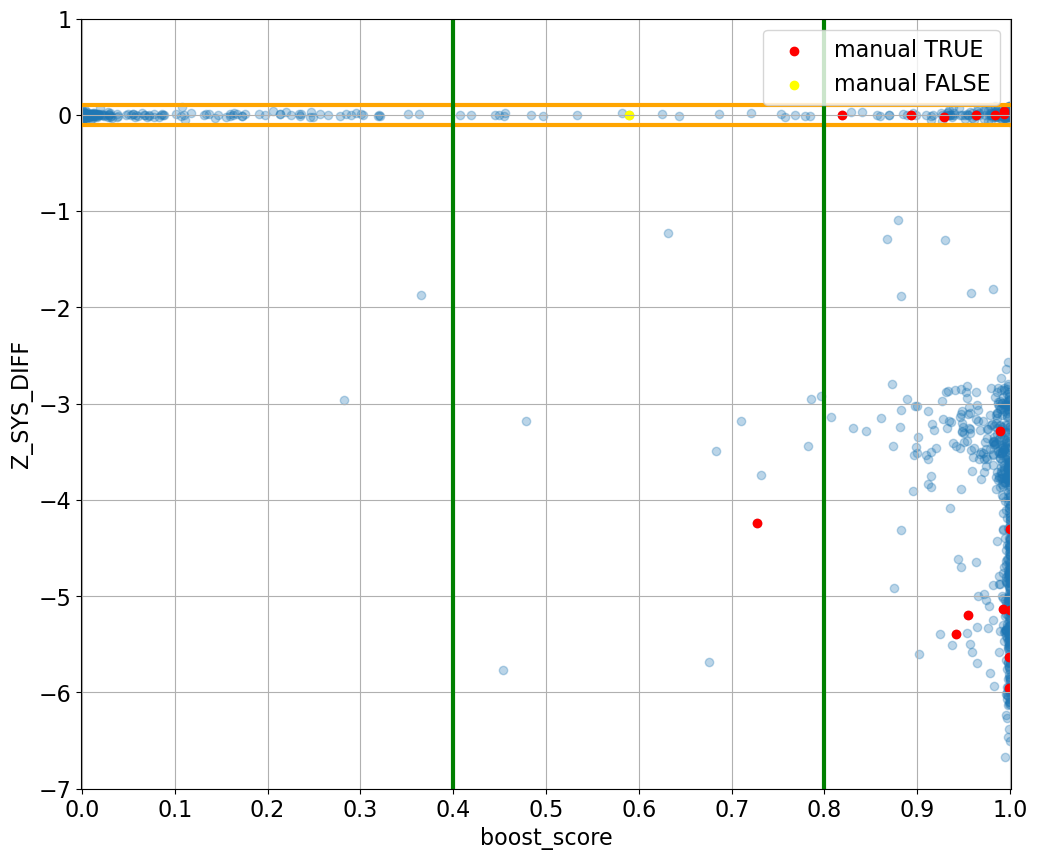

In [30]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim(-0.001, 1.001)
plt.ylim(-7.0, 1)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.grid()

t = dr16q[(dr16q['Z_SYS'] > -1) & (dr16q['Z'] >= 4)]

plt.scatter(t['preds'], t['Z_SYS_DIFF'], alpha=0.3)
plt.scatter(t[t['Gtest_zooTrue'] == True]['preds'], t[t['Gtest_zooTrue'] == True]['Z_SYS_DIFF'], color='r', label='manual TRUE')
plt.scatter(t[t['Gtest_zooTrue'] == False]['preds'], t[t['Gtest_zooTrue'] == False]['Z_SYS_DIFF'], color='yellow', label='manual FALSE')
plt.hlines([-0.1, 0.1], xmin=-1, xmax=2, colors='orange', linewidth=3)
plt.vlines([0.4, 0.8], ymin=-8, ymax=2, color='green', linewidth=3)

plt.xlabel('boost_score')
plt.ylabel('Z_SYS_DIFF')
plt.legend()
pass;

In [31]:
# dfs = []

# font = {'size': 16}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(12, 10))
# plt.xlim(-0.001, 1.001)
# plt.ylim(-7.0, 1)
# plt.xticks(np.arange(0.0, 1.1, 0.1))
# plt.grid()

# t00 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] < 0.1)]
# t00_01 = t00.iloc[np.random.choice(np.arange(t00.shape[0]), 4, replace=False)]
# dfs.append(t00_01)
# t01 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.1) & (t['preds'] < 0.2)]
# t01_01 = t01.iloc[np.random.choice(np.arange(t01.shape[0]), 2, replace=False)]
# dfs.append(t01_01)
# t02 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.2) & (t['preds'] < 0.3)]
# t02_01 = t02.iloc[np.random.choice(np.arange(t02.shape[0]), 2, replace=False)]
# dfs.append(t02_01)
# t03 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.3) & (t['preds'] < 0.4)]
# t03_01 = t03.iloc[np.random.choice(np.arange(t03.shape[0]), 2, replace=False)]
# dfs.append(t03_01)
# t04 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.4) & (t['preds'] < 0.8)]
# t04_01 = t04.iloc[np.random.choice(np.arange(t04.shape[0]), 5, replace=False)]
# dfs.append(t04_01)
# t05 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.8) & (t['preds'] < 0.9)]
# t05_01 = t05.iloc[np.random.choice(np.arange(t05.shape[0]), 3, replace=False)]
# dfs.append(t05_01)
# t06 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.9)]
# t06_01 = t06.iloc[np.random.choice(np.arange(t06.shape[0]), 7, replace=False)]
# dfs.append(t06_01)
# t07 = t[(t['Z_SYS_DIFF'] < -0.1) & (t['preds'] < 0.4)]
# t07_01 = t07.iloc[np.random.choice(np.arange(t07.shape[0]), t07.shape[0], replace=False)]
# dfs.append(t07_01)
# t08 = t[(t['Z_SYS_DIFF'] < -0.1) & (t['preds'] >= 0.4) & (t['preds'] < 0.8)]
# t08_01 = t08.iloc[np.random.choice(np.arange(t08.shape[0]), 5, replace=False)]
# dfs.append(t08_01)
# t09 = t[(t['Z_SYS_DIFF'] < -0.1) & (t['preds'] >= 0.8) & (t['preds'] < 0.9)]
# t09_01 = t09.iloc[np.random.choice(np.arange(t09.shape[0]), 3, replace=False)]
# dfs.append(t09_01)
# t10 = t[(t['Z_SYS_DIFF'] < -0.1) & (t['preds'] >= 0.9)]
# t10_01 = t10.iloc[np.random.choice(np.arange(t10.shape[0]), 7, replace=False)]
# dfs.append(t10_01)
# t11 = t[(np.abs(t['z_diff']) < 1.0) & (t['preds'] >= 0.5)]
# t11_01 = t11.iloc[np.random.choice(np.arange(t11.shape[0]), t11.shape[0], replace=False)]
# dfs.append(t11_01)
# t12 = t[(np.abs(t['z_diff']) > 1.0) & (t['preds'] <= 0.4)]
# t12_01 = t12.iloc[np.random.choice(np.arange(t12.shape[0]), t12.shape[0], replace=False)]
# dfs.append(t12_01)

# manual_data = pd.read_csv(f'{data_dir}/manual_data.csv')
# manual_data = pd.concat(dfs, axis=0)

# plt.scatter(manual_data['preds'], manual_data['Z_SYS_DIFF'], alpha=0.3)
# plt.hlines([-0.1, 0.1], xmin=-1, xmax=2, colors='orange', linewidth=3)
# plt.vlines([0.4, 0.8], ymin=-8, ymax=2, color='green', linewidth=3)

# plt.xlabel('boost_score')
# plt.ylabel('Z_SYS_DIFF')
# plt.legend()

# # manual_data.to_csv(f'{data_dir}/manual_data.csv', index=False)

In [32]:
# font = {'size': 16}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(12, 10))
# plt.grid()

# plt.scatter(manual_data['preds'], manual_data['z_diff'], alpha=0.3)

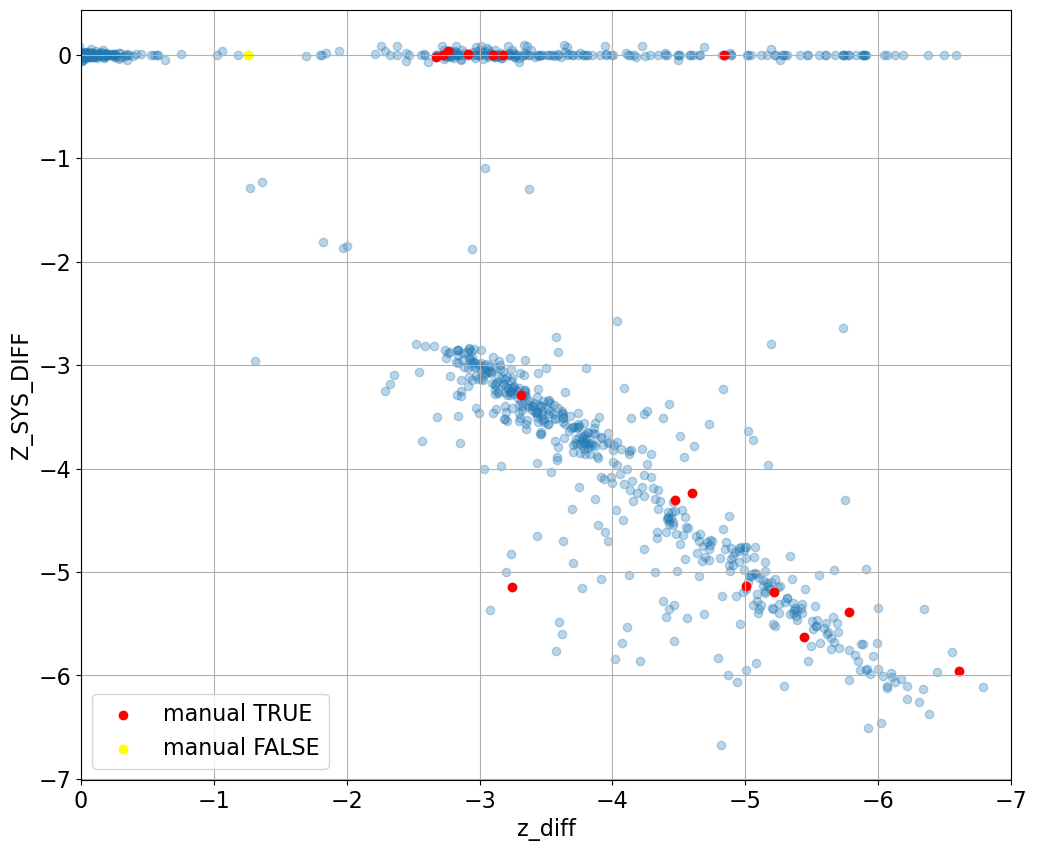

In [33]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim(0, -7)
# plt.ylim(-7.0, 1)
# plt.xticks(np.arange(0, -8, 1))
plt.grid()

t = dr16q[(dr16q['Z_SYS'] > -1) & (dr16q['Z'] >= 4)]

plt.scatter(t['z_diff'], t['Z_SYS_DIFF'], alpha=0.3)
plt.scatter(t[t['Gtest_zooTrue'] == True]['z_diff'], t[t['Gtest_zooTrue'] == True]['Z_SYS_DIFF'], color='r', label='manual TRUE')
plt.scatter(t[t['Gtest_zooTrue'] == False]['z_diff'], t[t['Gtest_zooTrue'] == False]['Z_SYS_DIFF'], color='yellow', label='manual FALSE')
# plt.hlines([-0.1, 0.1], xmin=-1, xmax=2, colors='orange', linewidth=3)
# plt.vlines([0.4, 0.8], ymin=-8, ymax=2, color='green', linewidth=3)

plt.xlabel('z_diff')
plt.ylabel('Z_SYS_DIFF')
plt.legend()
pass;

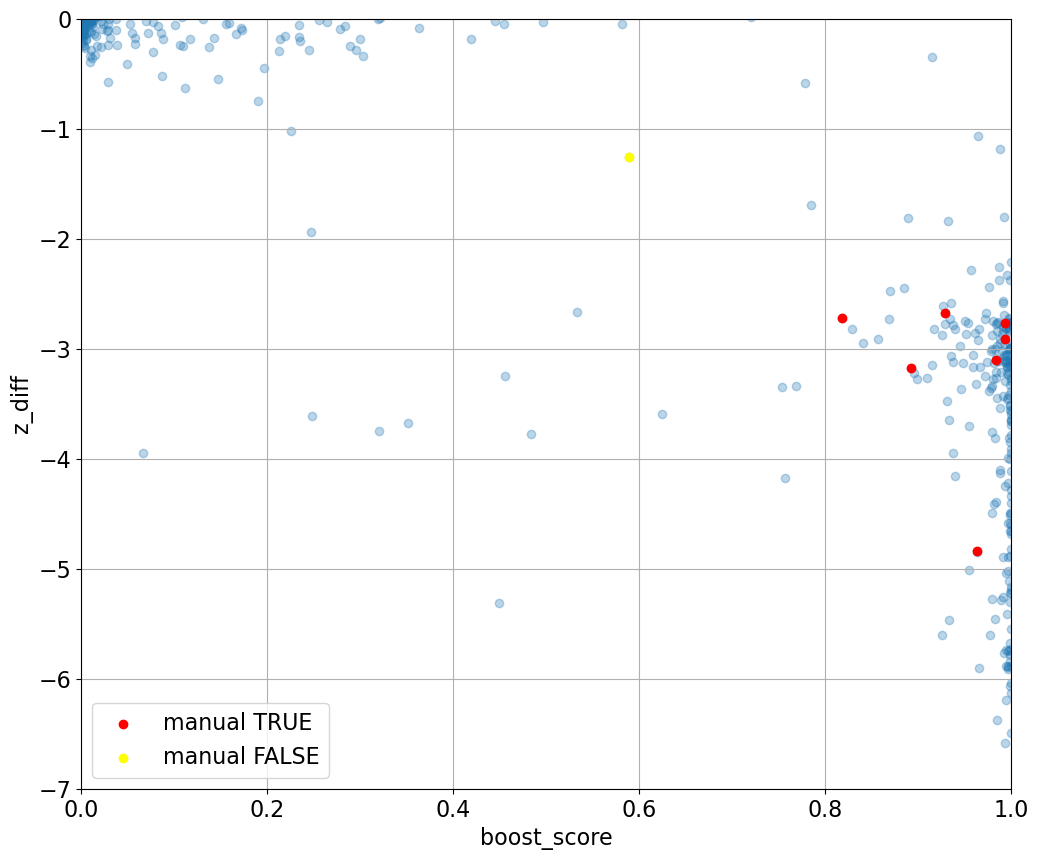

In [34]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim(0.0, 1.0)
plt.ylim(-7, 0.0)
plt.grid()

t = dr16q[np.abs(dr16q['Z_SYS_DIFF']) <= 0.1][(dr16q['Z_SYS'] > -1) & (dr16q['Z'] >= 4)]

plt.scatter(t['preds'], t['z_diff'], alpha=0.3)
plt.scatter(t[t['Gtest_zooTrue'] == True]['preds'], t[t['Gtest_zooTrue'] == True]['z_diff'], color='r', label='manual TRUE')
plt.scatter(t[t['Gtest_zooTrue'] == False]['preds'], t[t['Gtest_zooTrue'] == False]['z_diff'], color='yellow', label='manual FALSE')
# plt.hlines([-0.1, 0.1], xmin=-1, xmax=2, colors='orange', linewidth=3)
# plt.vlines([0.4, 0.8], ymin=-8, ymax=2, color='green', linewidth=3)

plt.ylabel('z_diff')
plt.xlabel('boost_score')
plt.legend()
pass;

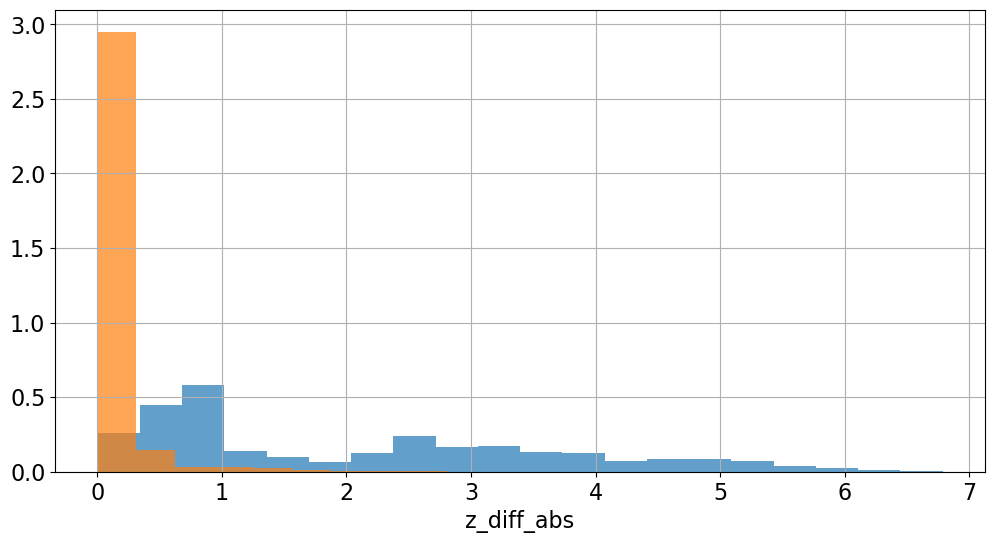

In [35]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()

plt.hist(prop_dens[prop_dens['dr16q_prop']]['z_diff_abs'], bins=20, density=True, alpha=0.7)
plt.hist(prop_dens[prop_dens['train20']]['z_diff_abs'], bins=20, density=True, alpha=0.7)
plt.xlabel('z_diff_abs')
# plt.title('boost_outliers')
pass;

In [36]:
start = time.time()
naive_log = LogisticRegression(solver='lbfgs', C=1, random_state=0).fit(X_01[:, 0].reshape(-1, 1), y_01)
print('naive train time: ', time.time() - start)
a = naive_log.coef_[0][0]
b = naive_log.intercept_[0] 
print(a, b, -b/a)
prop_dens_log = prop_dens[['z_diff_abs', 'Z', 'dr16q_prop', 'train20', 'target']].copy()
start = time.time()
prop_dens_log_preds = naive_log.predict_proba(prop_dens_log['z_diff_abs'].values.reshape(-1, 1))[:, 1]
print('naive inf time: ', time.time() - start)
prop_dens_log['preds'] = prop_dens_log_preds
prop_dens_log_z = prop_dens_log[prop_dens_log['Z'] >= 4]

naive train time:  0.23091793060302734
2.1910946773530973 -1.3560147745273363 0.6188754819875878
naive inf time:  0.0593409538269043


In [37]:
# font = {'size': 16}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(12, 6))
# plt.grid()

# plt.hist(prop_dens_log_z[prop_dens_log_z['dr16q_prop']]['preds'], bins=20, density=False, alpha=0.7, label='dr16q_prop')
# plt.hist(prop_dens_log_z[prop_dens_log_z['train20']]['preds'], bins=20, density=False, alpha=0.7, label='train20')
# plt.legend()
# pass;

In [38]:
prop_dens[(prop_dens['Z'] > 6.5) & (prop_dens['target'] == 0)].drop_duplicates(subset=['RA', 'DEC'], inplace=False, keep='last')

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
696377,None,36.507807,3.049838,6.541200,None,None,None,None,False,False,...,0.359223,6.5881,0.798716,0.923953,0.100922,None,-5.617247,5.617247,0,0.088276
696429,None,174.891806,49.894562,6.795398,None,None,None,None,False,False,...,0.375718,0.837,0.479773,0.8006,0.406705,None,-5.994798,5.994798,0,0.313758


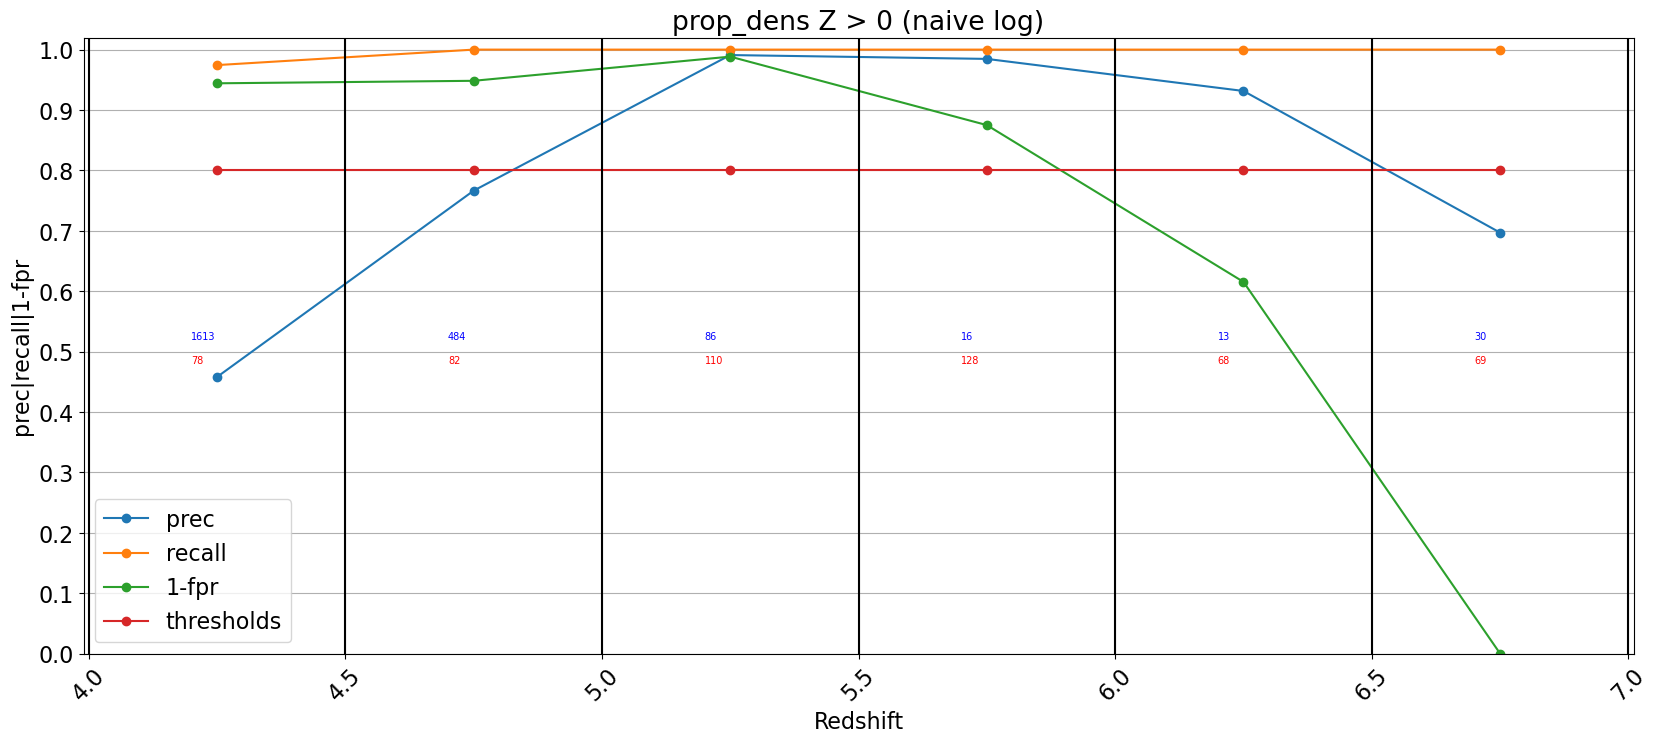

In [39]:
# manual_prec = []
# for i in range(len(quants)-1):
#     t = ge[(ge['Z_DR16Q'] >= quants[i]) & (ge['Z_DR16Q'] <= quants[i+1])]
#     manual_prec.append(t['Gtest_zooTrue'].sum() / t.shape[0])

# thrs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
thrs = [0.8] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_log_z, quants, thrs, 'prop_dens Z > 0 (naive log)')
# plt.plot((quants[1:] + quants[:-1]) / 2, manual_prec, label=f'manual_prec', marker='o')
# plt.legend();

In [40]:
X_01_z4 = np.concatenate([train_20_01[train_20_01['Z'] >= 4][features_list].values, superset_01[superset_01['Z'] >= 4][features_list].values], axis=0)
y_01_z4 = np.concatenate([train_20_01[train_20_01['Z'] >= 4]['target'].values, superset_01[superset_01['Z'] >= 4]['target'].values], axis=0).astype(int)
X_02_z4 = np.concatenate([train_20_02[train_20_02['Z'] >= 4][features_list].values, superset_02[superset_02['Z'] >= 4][features_list].values], axis=0)
y_02_z4 = np.concatenate([train_20_02[train_20_02['Z'] >= 4]['target'].values, superset_02[superset_02['Z'] >= 4]['target'].values], axis=0).astype(int)

In [41]:
naive_log_z4 = LogisticRegression(solver='lbfgs', C=1, random_state=0).fit(X_01_z4[:, 0].reshape(-1, 1), y_01_z4)
a = naive_log_z4.coef_[0][0]
b = naive_log_z4.intercept_[0] 
print(a, b, -b/a)
prop_dens_log_z4 = prop_dens[['z_diff_abs', 'Z', 'dr16q_prop', 'train20', 'target']].copy()
prop_dens_log_z4_preds = naive_log_z4.predict_proba(prop_dens_log['z_diff_abs'].values.reshape(-1, 1))[:, 1]
prop_dens_log_z4['preds'] = prop_dens_log_z4_preds
prop_dens_log_z4_z = prop_dens_log_z4[prop_dens_log_z4['Z'] >= 4]

1.6780002981698414 -2.552401300692179 1.5210970483593047


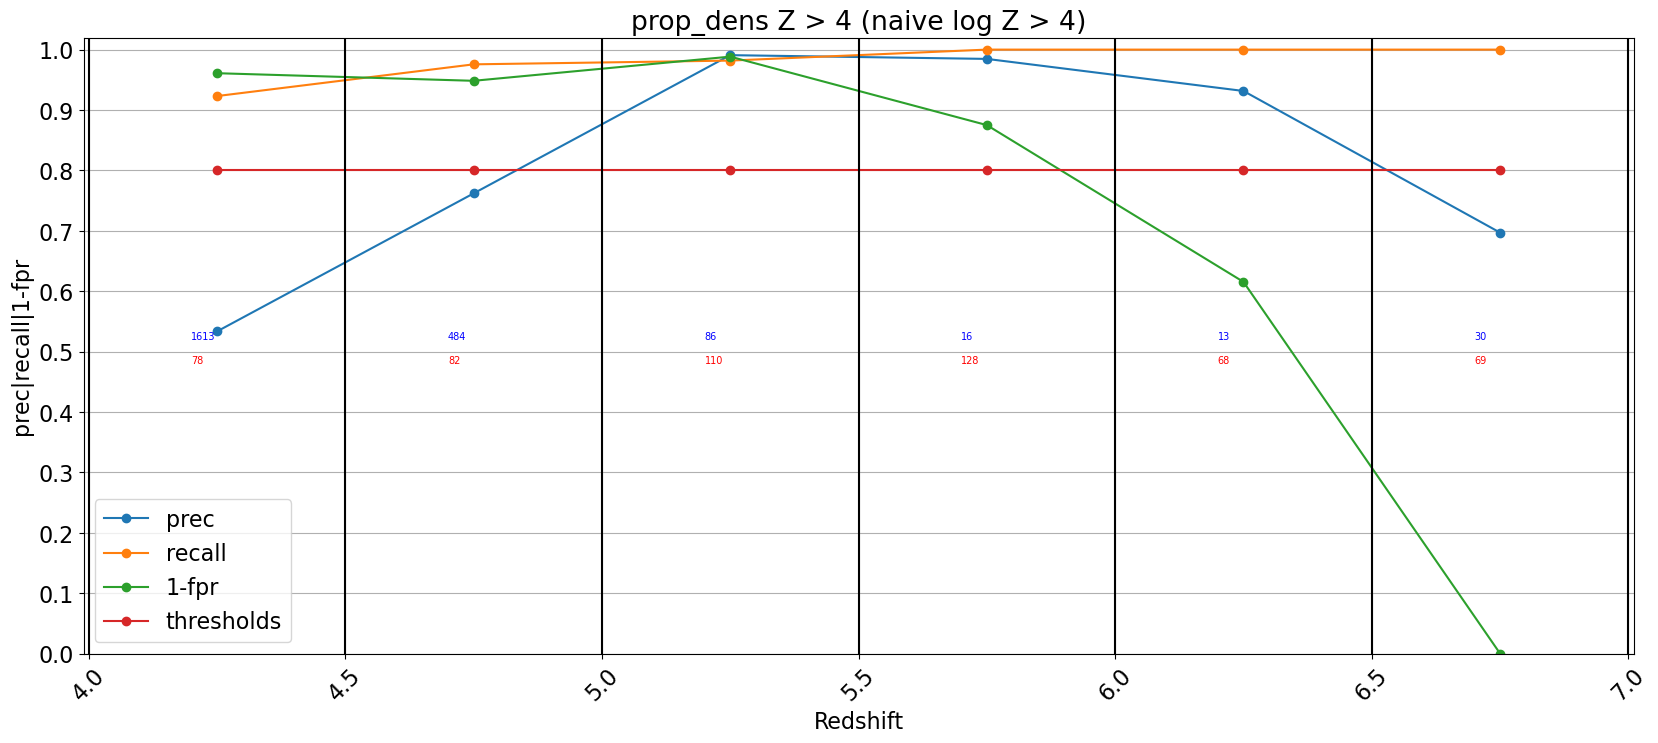

In [42]:
thrs = [0.8] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_log_z4_z, quants, thrs, 'prop_dens Z > 4 (naive log Z > 4)')

In [43]:
start = time.time()
rf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=0, n_jobs=12).fit(X_01, y_01)
print('rf train time: ', time.time() - start)
prop_dens_rf = prop_dens.copy()
start = time.time()
prop_dens_rf_preds = rf.predict_proba(prop_dens_rf[features_list].values)[:, 1]
print('rf inf time: ', time.time() - start)
prop_dens_rf['preds'] = prop_dens_rf_preds
prop_dens_rf_z = prop_dens_rf[prop_dens_rf['Z'] >= 4]

rf train time:  529.9085204601288
rf inf time:  16.04221534729004


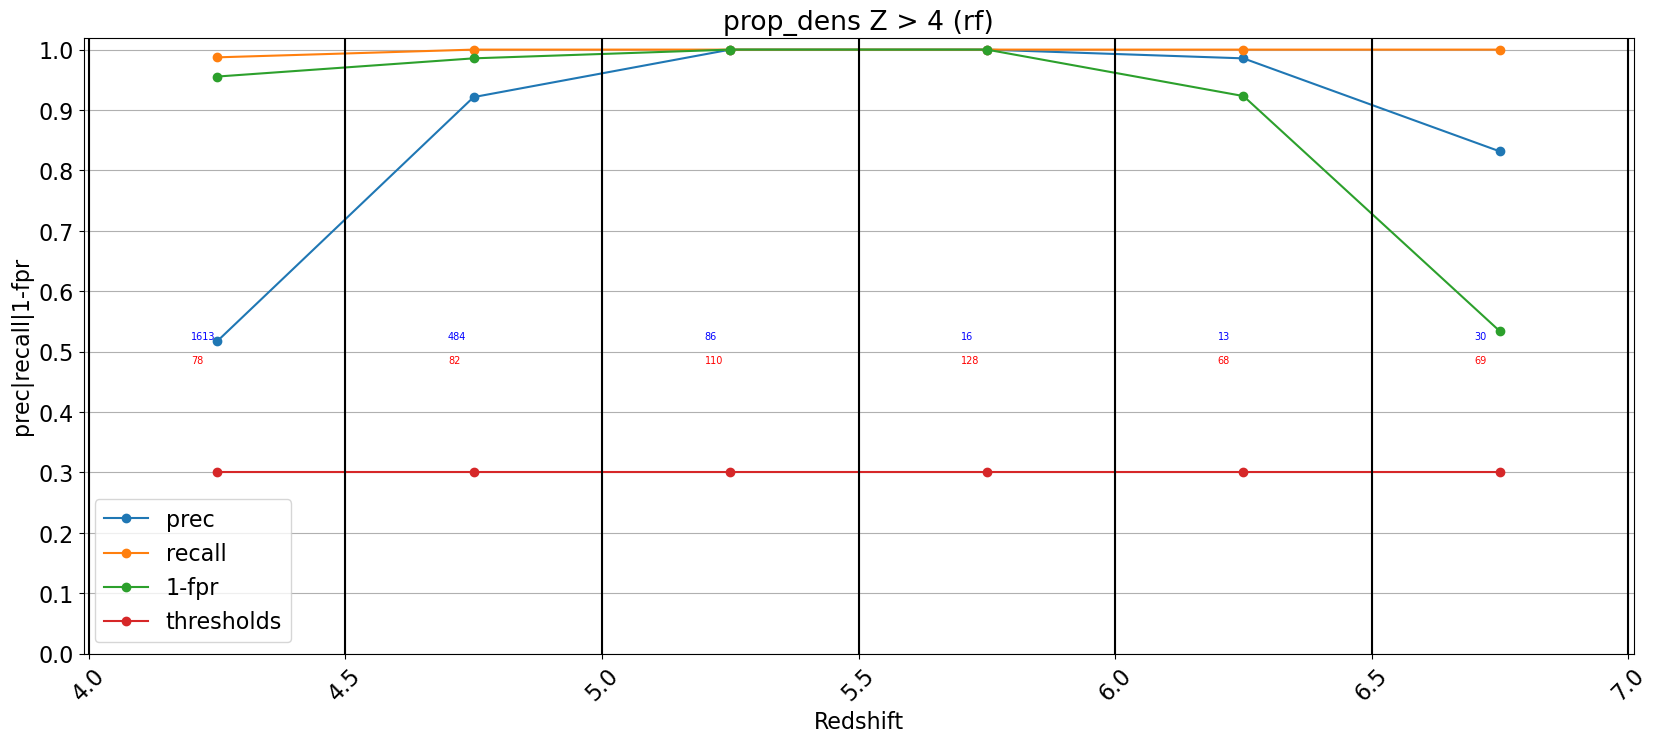

In [44]:
thrs = [0.3] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_rf_z, quants, thrs, 'prop_dens Z > 4 (rf)')

In [45]:
# svm_ = svm.SVC().fit([[0.1, 1.1], [2.2, 3.2]], [0, 1])

In [46]:
# start = time.time()
# svm_ = svm.SVC().fit(X_01, y_01)
# print('svm train time: ', time.time() - start)
# prop_dens_svm = prop_dens.copy()
# start = time.time()
# prop_dens_svm_preds = svm_.predict_proba(prop_dens_svm[features_list].values)[:, 1]
# print('svm inf time: ', time.time() - start)
# prop_dens_svm['preds'] = prop_dens_svm_preds
# prop_dens_svm_z = prop_dens_svm[prop_dens_svm['Z'] >= 4]

In [47]:
# thrs = [0.3] * (len(quants)-1)

# _, _, _ = plot_all(prop_dens_svm_z, quants, thrs, 'prop_dens Z > 4 (svm)')

boost:  0.9985398767863878
naive:  0.9691865387033234
rf:  0.9924579858346254


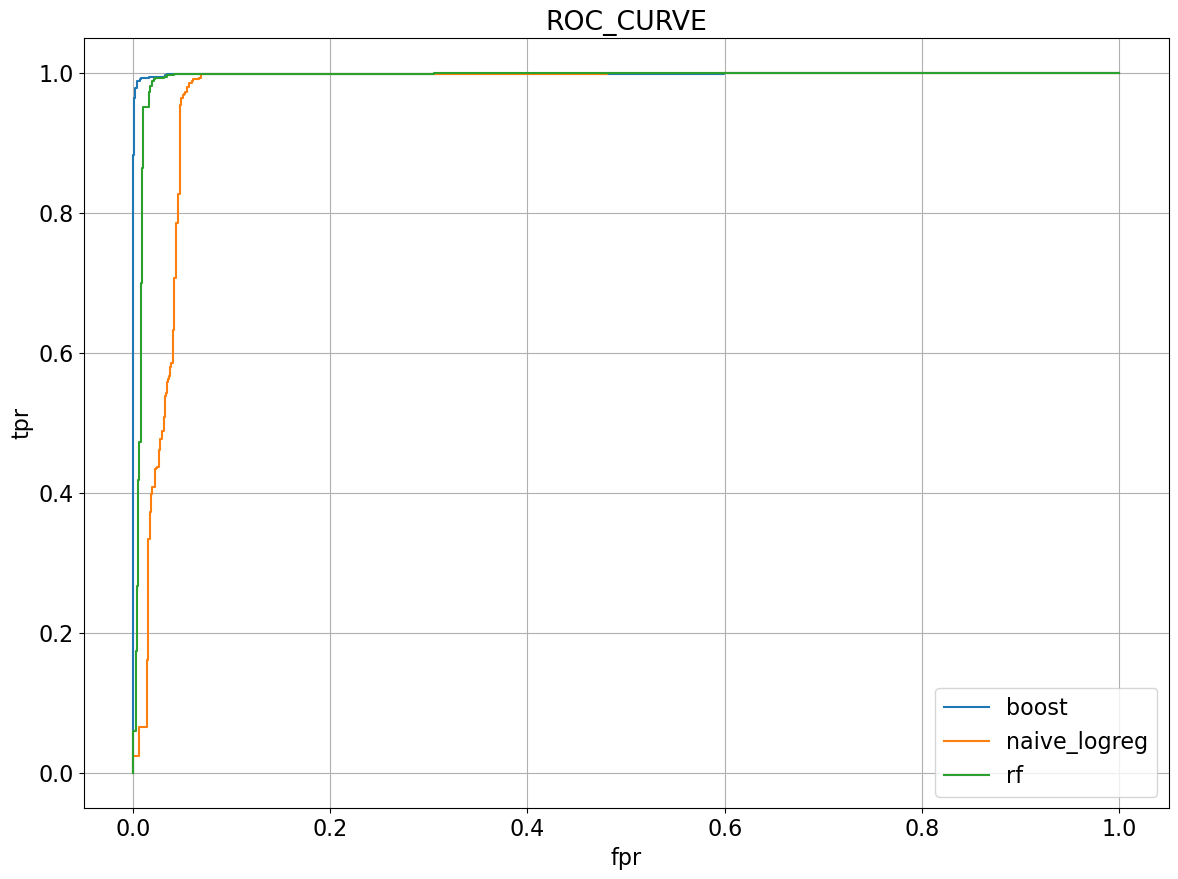

In [48]:
fpr_boost, tpr_boost, thrs_boost = roc_curve(prop_dens_z['target'], prop_dens_z['preds'], pos_label=1)
fpr_naive_log, tpr_naive_log, thrs_naive_log = roc_curve(prop_dens_log_z['target'], prop_dens_log_z['preds'], pos_label=1)
fpr_rf, tpr_rf, thrs_rf = roc_curve(prop_dens_rf_z['target'], prop_dens_rf_z['preds'], pos_label=1)

print('boost: ', roc_auc_score(prop_dens_z['target'], prop_dens_z['preds']))
print('naive: ', roc_auc_score(prop_dens_log_z['target'], prop_dens_log_z['preds']))
print('rf: ', roc_auc_score(prop_dens_rf_z['target'], prop_dens_rf_z['preds']))

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 10))
plt.grid()

plt.plot(fpr_boost, tpr_boost, label='boost')
plt.plot(fpr_naive_log, tpr_naive_log, label='naive_logreg')
plt.plot(fpr_rf, tpr_rf, label='rf')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC_CURVE')
plt.legend()
pass;

In [52]:
full[full['dr16q_prop']]

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,conf21_z,max22_z,conf22_z,max35_z,conf35_z,Gtest_zooTrue,z_diff,z_diff_abs,target,preds
82,b'7750-58402-0178',0.023199,33.677090,2.374468,1.695454,0.002444,-0.679013,0.679013,True,True,...,0.613625,1.635,0.836528,1.611,0.780039,None,-0.763468,0.763468,None,None
409,b'7751-58081-0010',0.110519,32.520371,6.537026,3.9,-1.0,-2.637026,2.637026,True,True,...,0.679745,0.67,0.366796,0.8,0.541579,None,-5.737026,5.737026,None,None
647,b'7666-57339-0127',0.182396,24.708938,2.812042,2.055525,0.002691,-0.756517,0.756517,True,True,...,0.435133,2.068,0.623723,2.120766,0.951724,None,-0.691276,0.691276,None,None
703,b'7749-58073-0317',0.200670,30.933965,3.346067,0.884013,0.0006,-2.462054,2.462054,True,True,...,0.834586,0.757478,0.543481,0.771,0.717006,None,-2.575067,2.575067,None,None
1533,b'11277-58450-0221',0.447432,8.302736,1.619089,1.096916,0.001626,-0.522173,0.522173,True,True,...,0.250491,2.83514,0.406042,1.327,0.388721,None,-0.292089,0.292089,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695068,b'7696-57655-0810',359.586721,30.006652,7.012407,1.040394,0.000788,-5.972012,5.972012,True,True,...,0.265288,1.619793,0.314681,0.916,0.264474,None,-6.096407,6.096407,None,None
695124,b'7895-57659-0798',359.602008,-3.155726,4.471740,1.416833,0.002218,-3.054907,3.054907,True,True,...,0.913761,1.2609,0.711733,1.4614,0.979128,None,-3.01034,3.01034,None,None
695441,b'7848-56959-0147',359.688329,-0.107161,1.077307,0.638959,0.003373,-0.438348,0.438348,True,True,...,0.437292,1.976696,0.526514,1.718474,0.514749,None,0.641167,0.641167,None,None
696013,b'7895-57659-0851',359.854208,-3.659661,3.333653,0.894096,0.000511,-2.439556,2.439556,True,True,...,0.640537,0.69,0.685679,0.929,0.826316,None,-2.404653,2.404653,None,None
